## In this colab Object detection model will be implemented and will be deployed for arduino microcontroller

In [26]:
# import necessary libraries
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.15.0
The following GPU devices are available: 


In [27]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmp0ctdw9b1.jpg.


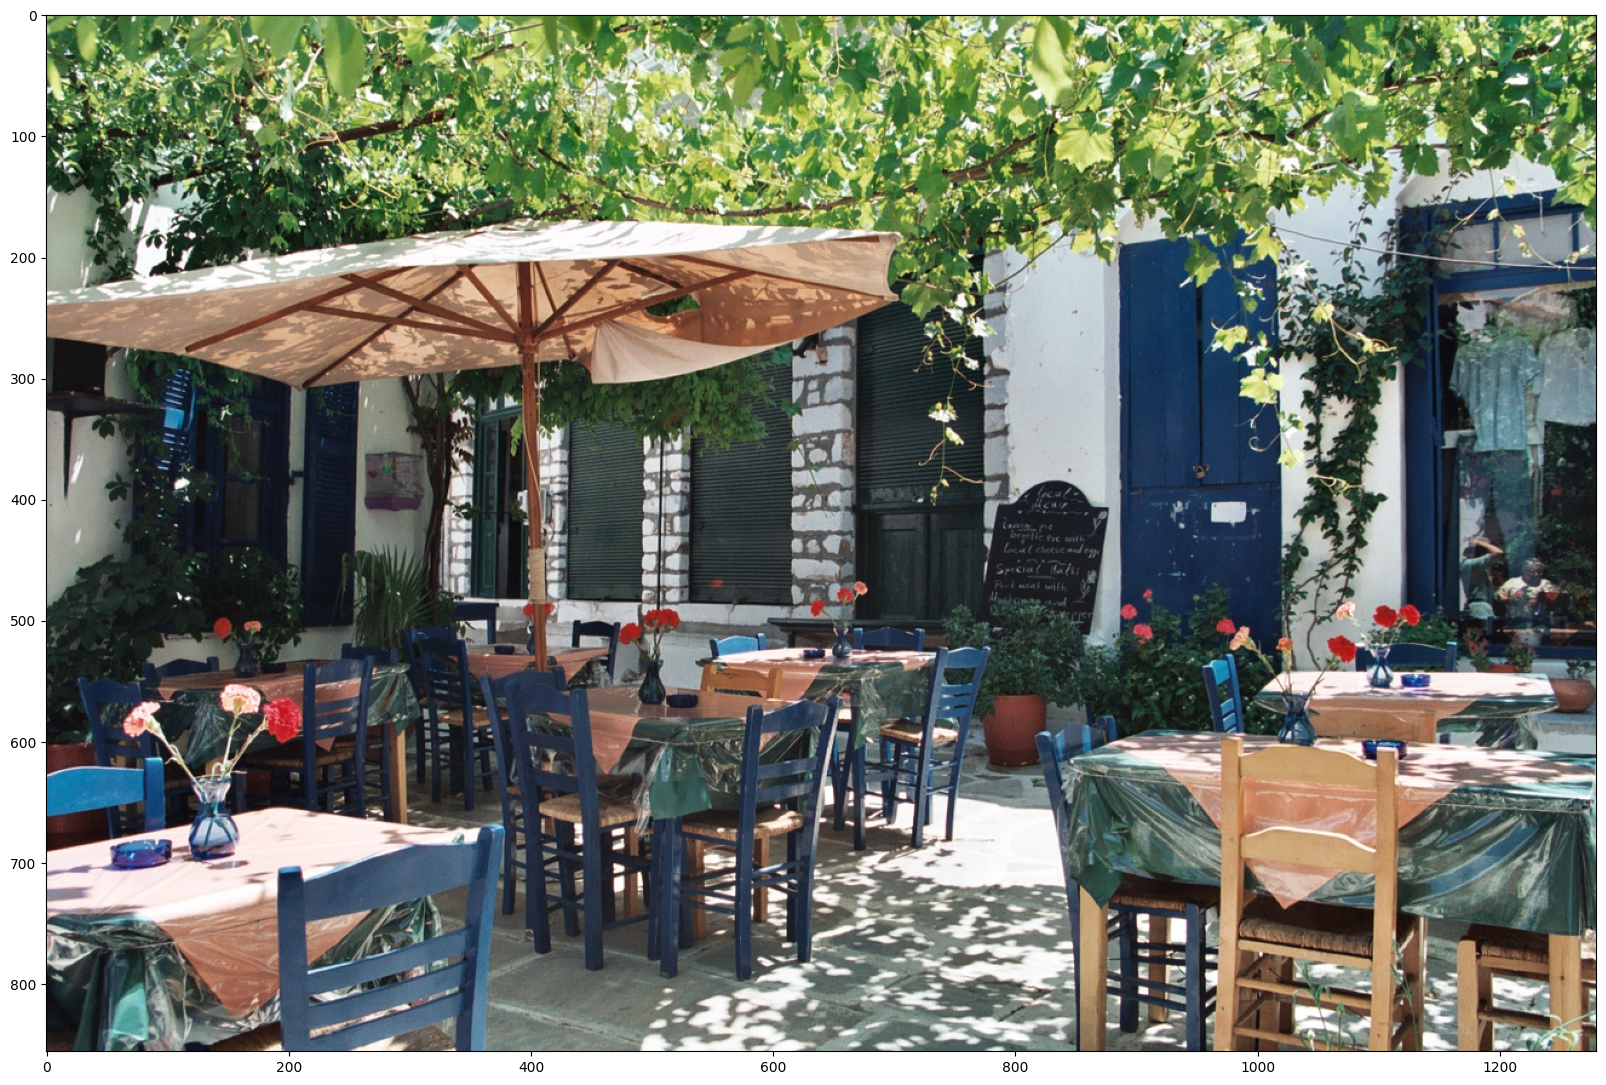

In [28]:
# get sample image and preprocess and plot
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [29]:
# get the pretrained model
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

In [30]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [47]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  # just for checking
  print(result["detection_class_entities"])

  if b'Human face' in result["detection_class_entities"]:
    return True
  else:
    return False

  """

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

  """

In [45]:
result = run_detector(detector, downloaded_image_path)
print(result)

Found 100 objects.
Inference time:  35.25809288024902
[b'Chair' b'Table' b'Table' b'Chair' b'Table' b'Chair' b'Tree' b'Chair'
 b'Chair' b'Tree' b'Table' b'Chair' b'Flowerpot' b'Table' b'Houseplant'
 b'Chair' b'Kitchen & dining room table' b'Kitchen & dining room table'
 b'Table' b'Chair' b'Umbrella' b'Building' b'Chair' b'Chair' b'Chair'
 b'Table' b'House' b'Table' b'Chair' b'Table' b'Chair' b'Chair' b'Plant'
 b'Tent' b'Houseplant' b'Tree' b'Table' b'Table' b'Building' b'Chair'
 b'Chair' b'Plant' b'Flower' b'Chair' b'Chair' b'Table' b'House' b'Table'
 b'Tree' b'Chair' b'Chair' b'Plant' b'Kitchen & dining room table'
 b'Kitchen & dining room table' b'Houseplant' b'Chair' b'Tree' b'Chair'
 b'Tree' b'Table' b'Plant' b'Chair' b'Table' b'Umbrella' b'House'
 b'Kitchen & dining room table' b'Building' b'Table' b'Coffee table'
 b'Chair' b'Chair' b'Chair' b'House' b'Table' b'Chair' b'Toy' b'Tree'
 b'Chair' b'Chair' b'Table' b'Chair' b'Coffee table' b'Furniture'
 b'Window' b'Building' b'Chair' b

In [33]:
def plot_image(image_path):
  # Load the image
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)

  # Preprocess the image (optional, depending on your needs)
  # For example, resize the image
  image = tf.image.resize(image, [224, 224])

  # Plot the image
  plt.imshow(image.numpy().astype("uint8"))
  plt.axis('off')  # Turn off axis numbers
  plt.show()

In [34]:
image_path = "/content/drive/MyDrive/Data/download.jpg";

In [48]:
result = run_detector(detector, image_path)
print(result)

Found 100 objects.
Inference time:  35.53958582878113
[b'Bicycle' b'Car' b'Bicycle wheel' b'Wheel' b'Bicycle wheel' b'Man'
 b'Person' b'Clothing' b'Tree' b'Wheel' b'Wheel' b'Tree' b'Building'
 b'Wheel' b'Window' b'Wheel' b'Tire' b'Window' b'Human face' b'Window'
 b'Tire' b'Window' b'House' b'Wheel' b'Wheel' b'Wheel' b'Plant' b'Tire'
 b'Building' b'Tree' b'Tire' b'Building' b'Tree' b'Window'
 b'Bicycle wheel' b'Tree' b'Window' b'Wheel' b'Window' b'Window' b'Mammal'
 b'Window' b'Bicycle wheel' b'Wheel' b'House' b'Bicycle wheel'
 b'Human head' b'Van' b'Tire' b'Bicycle' b'House' b'Bicycle' b'Window'
 b'Wheel' b'Tree' b'Wheel' b'Wheel' b'Bicycle' b'Human hair' b'Wheel'
 b'Tire' b'Wheel' b'Human body' b'Man' b'Tire' b'Bicycle wheel' b'Wheel'
 b'Wheel' b'Tire' b'Clothing' b'Building' b'House' b'Wheel'
 b'Land vehicle' b'Human arm' b'Window' b'Tree' b'Bicycle wheel'
 b'Land vehicle' b'Person' b'Bicycle' b'Wheel' b'Auto part'
 b'Bicycle wheel' b'Bicycle wheel' b'House' b'Clothing' b'Bicycle whe

In [41]:
result = run_detector(detector,"/content/drive/MyDrive/Data/WIN_20240113_22_57_19_Pro.jpg")
print(result)

Found 100 objects.
Inference time:  37.62217307090759
False


In [49]:
result = run_detector(detector,"/content/drive/MyDrive/Data/WIN_20240113_23_05_14_Pro.jpg")
print(result)

Found 100 objects.
Inference time:  36.772356271743774
[b'Human face' b'Man' b'Glasses' b'Clothing' b'Person' b'Human face'
 b'Shelf' b'Woman' b'Clothing' b'Man' b'Bookcase' b'Shelf' b'Human arm'
 b'Clothing' b'Building' b'Glasses' b'Woman' b'Man' b'Human head'
 b'Swim cap' b'Jacket' b'Human hair' b'Person' b'Human nose' b'Human eye'
 b'Toy' b'Building' b'Person' b'Shelf' b'Furniture' b'Woman' b'Human head'
 b'House' b'Sports equipment' b'Person' b'Person' b'Fashion accessory'
 b'Book' b'Girl' b'Human arm' b'Clothing' b'Man' b'Human mouth'
 b'Human body' b'Human face' b'Person' b'Sculpture' b'Woman' b'Human face'
 b'Clothing' b'Bookcase' b'Woman' b'Jacket' b'Shelf' b'Clothing' b'Boy'
 b'Human eye' b'Man' b'Shelf' b'Helmet' b'Human body' b'Fashion accessory'
 b'Book' b'Mammal' b'Building' b'Shelf' b'Building' b'Human hand' b'Shelf'
 b'Man' b'Human head' b'Human leg' b'House' b'Bookcase' b'Clothing'
 b'Shelf' b'Book' b'Book' b'Car' b'Mammal' b'Furniture' b'Clothing'
 b'Mammal' b'Mammal' 